In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
%matplotlib inline
torch.set_printoptions(sci_mode=False)
np.printoptions(suppress=True, precision=4)

In [2]:
# load dataset
def read(file_path, is_image=True):
  import os
  with open(os.path.join("../tmp", file_path), 'rb') as f:
    data = f.read()
    if is_image: return np.frombuffer(data[0x10:], dtype=np.uint8).reshape(-1, 28, 28)
    else: return np.frombuffer(data[8:], dtype=np.uint8)

X_train = read("train-images-idx3-ubyte")
Y_train = read("train-labels-idx1-ubyte", is_image=False)
X_test = read("t10k-images-idx3-ubyte")
Y_test = read("t10k-labels-idx1-ubyte", is_image=False)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [3]:
# model
class BobNet(nn.Module):
    def __init__(self):
        super(BobNet, self).__init__()
        self.l1 = nn.Linear(784, 128, bias=False)
        self.l2 = nn.Linear(128, 10, bias=False)
        self.sm = nn.LogSoftmax(dim=1)
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        x = self.sm(x)
        return x

loss 0.09 accuracy 0.97: 100%|██████████| 1000/1000 [00:02<00:00, 476.45it/s]


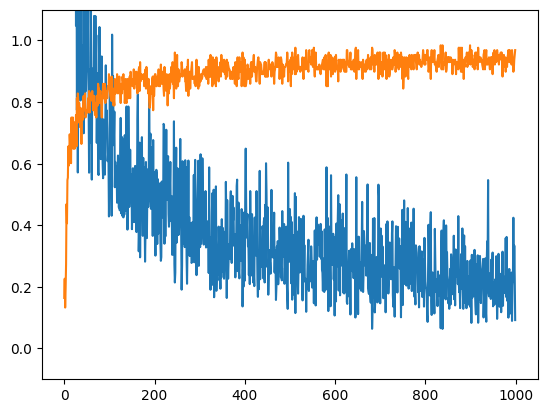

In [4]:
# training
model = BobNet()

# protip: if you like accuracy like 96 not like 93, next time through the notebook, consider
# CHAD MODE WEIGHT INIT WITH NUMPY
# instead of virgin torch init mode
"""
with torch.no_grad():
  model.l1.weight.copy_(torch.tensor(layer_init(784, 128).T))
  model.l2.weight.copy_(torch.tensor(layer_init(128, 10).T))
"""

BS = 128
loss_function = nn.NLLLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
losses, accuracies = [], []
for i in (t := trange(1000)):
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = torch.tensor(X_train[samp]).reshape((-1, 28*28)).float()
    Y = torch.tensor(Y_train[samp]).long()
    model.zero_grad()
    out = model(X)
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    loss = loss_function(out, Y)
    loss = loss.mean()
    loss.backward()
    optim.step()
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
plt.ylim(-0.1, 1.1)
plt.plot(losses)
plt.plot(accuracies)

In [5]:
# evaluation
Y_test_preds = torch.argmax(model(torch.tensor(X_test).reshape((-1, 28*28)).float()), dim=1).numpy()
(Y_test == Y_test_preds).mean().item()

0.9281

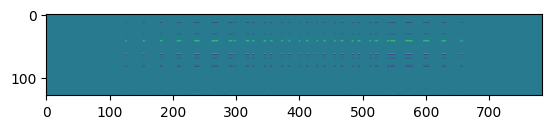

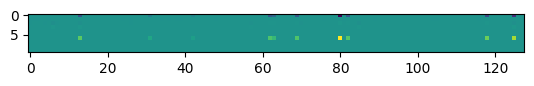

In [6]:
# gradients in torch
samp = [0,1,2,3]
model.zero_grad()
out = model(torch.tensor(X_test[samp].reshape((-1, 28*28))).float())
out.retain_grad()
loss = loss_function(out, torch.tensor(Y_test[samp]).long()).mean()
loss.retain_grad()
loss.backward()
plt.imshow(model.l1.weight.grad)
plt.figure()
plt.imshow(model.l2.weight.grad)

In [7]:
# copy weights from pytorch
l1 = model.l1.weight.detach().numpy().T
l2 = model.l2.weight.detach().numpy().T

# numpy forward pass
def forward(x):
    x = x.dot(l1)
    x = np.maximum(x, 0)
    x = x.dot(l2)
    return x

def numpy_eval():
    Y_test_preds_out = forward(X_test.reshape((-1, 28*28)))
    Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
    return (Y_test == Y_test_preds).mean().item()

numpy_eval()

0.9281

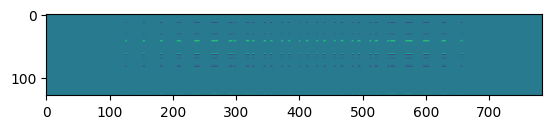

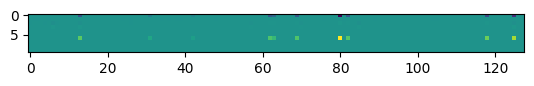

In [8]:
# forward and backward passes in numpy

def logsumexp(x):
    #return np.log(np.exp(x).sum(axis=1))
    # http://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
    c = x.max(axis=1)
    return c + np.log(np.exp(x-c.reshape((-1, 1))).sum(axis=1))

def forward_backward(x, y):
    out = np.zeros((len(y), 10), np.float32)
    out[range(out.shape[0]), y] = 1

    # forward pass
    x_l1 = x.dot(l1)
    x_relu = np.maximum(x_l1, 0)
    x_l2 = x_relu.dot(l2)
    x_lsm = x_l2 - logsumexp(x_l2).reshape((-1, 1))
    x_loss = (-out * x_lsm).mean(axis=1)

    # backward pass
    d_out = -out / len(y)

    # derivative of logsoftmax
    # https://github.com/torch/nn/blob/master/lib/THNN/generic/LogSoftMax.c
    dx_sm = d_out - np.exp(x_lsm) * d_out.sum(axis=1).reshape((-1, 1))

    # derivative of x_l2
    d_l2 = x_relu.T.dot(dx_sm)
    dx_relu = dx_sm.dot(l2.T)

    # derivative of relu
    dx_l1 = (x_relu > 0).astype(np.float32) * dx_relu

    # derivative of l1
    d_l1 = x.T.dot(dx_l1)

    return x_loss, x_l2, d_l1, d_l2

samp = [0,1,2,3]
x_loss, x_l2, d_l1, d_l2 = forward_backward(X_test[samp].reshape((-1, 28*28)), Y_test[samp])
plt.imshow(d_l1.T)
plt.figure()
plt.imshow(d_l2.T)


loss 0.01 accuracy 0.98: 100%|██████████| 1000/1000 [00:00<00:00, 1069.44it/s]


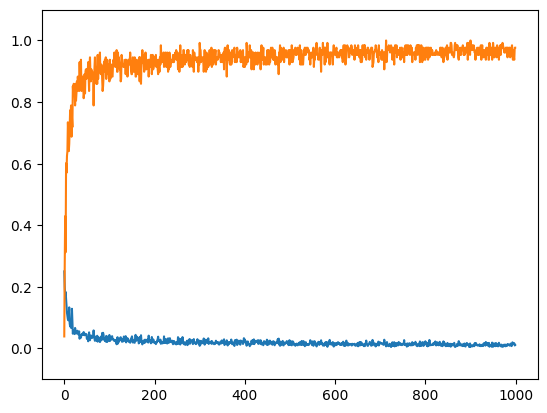

In [9]:
def layer_init(m, h):
    # gaussian is strong
    # ret = np.random.randn(m, h)/np.sqrt(m*h)
    # uniform is stronger
    ret = np.random.uniform(-1., 1., size=(m,h))/np.sqrt(m*h)
    return ret.astype(np.float32)

l1 = layer_init(784, 128)
l2 = layer_init(128, 10)

lr = 0.001
BS = 128
losses, accuracies = [], []
for i in (t := trange(1000)):
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = X_train[samp].reshape((-1, 28*28))
    Y = Y_train[samp]
    x_loss, x_l2, d_l1, d_l2 = forward_backward(X, Y)
    
    cat = np.argmax(x_l2, axis=1)
    accuracy = (cat == Y).mean()

    # SGD
    l1 = l1 - lr*d_l1
    l2 = l2 - lr*d_l2

    loss = x_loss.mean()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

plt.ylim(-0.1, 1.1)
plt.plot(losses)
plt.plot(accuracies)

In [10]:
# evaluate on test set
# over 96% with numpy, wow numpy is better than pytorch!
# note: add 0.01% more accuracy with float16
numpy_eval()

0.9622

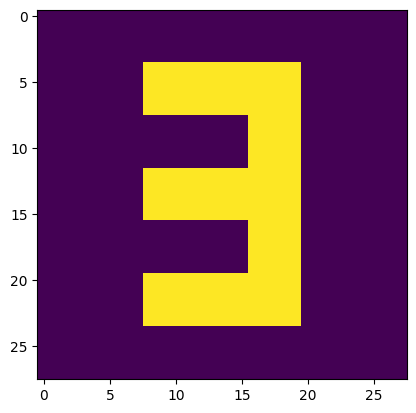

In [11]:
# can it recognize 3?
m = [[0,0,0,0,0,0,0],
     [0,0,1,1,1,0,0],
     [0,0,0,0,1,0,0],
     [0,0,1,1,1,0,0],
     [0,0,0,0,1,0,0],
     [0,0,1,1,1,0,0],
     [0,0,0,0,0,0,0]]
# upscale to 28x28
m = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in m])
plt.imshow(m.reshape(28, 28))

In [12]:
# what is it?
x = m.reshape(1, -1).dot(l1)
x = np.maximum(x, 0)
x = x.dot(l2)
np.argmax(x).item()

3